# Preprocessing Part2  Jupiter Notebook: Extracting data from our csv and preparing it for the machine learning model
This is the second  preprocessing notebook. This notebook deals with processing the csv generated by the first notebook (preprocessed_data.csv) script,adds a new column called "Average Score" that displays the average score per each review and finally removes the "date column" as that is unnededed for this machine learning project.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:

#first let's take a look at a general trend in the average score of reviews over time:
df=pd.read_csv("preprocessed_data.csv")

#convert the dates into datetime:
df["Dates"]= pd.to_datetime(df["Dates"])

In [3]:
df.head()

,Unnamed: 0,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews,Average Score
0,0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0,1.00
1,1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0,1.00
2,2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0,1.50
3,3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0,1.75
4,4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0,1.75


Visualise the data over time to see if date is an important feature or not (I suspespect not)

Text(0.5, 1.0, 'Average Scores of Virgin Media Reviews from 07/06/2018 to 15/11/2022')

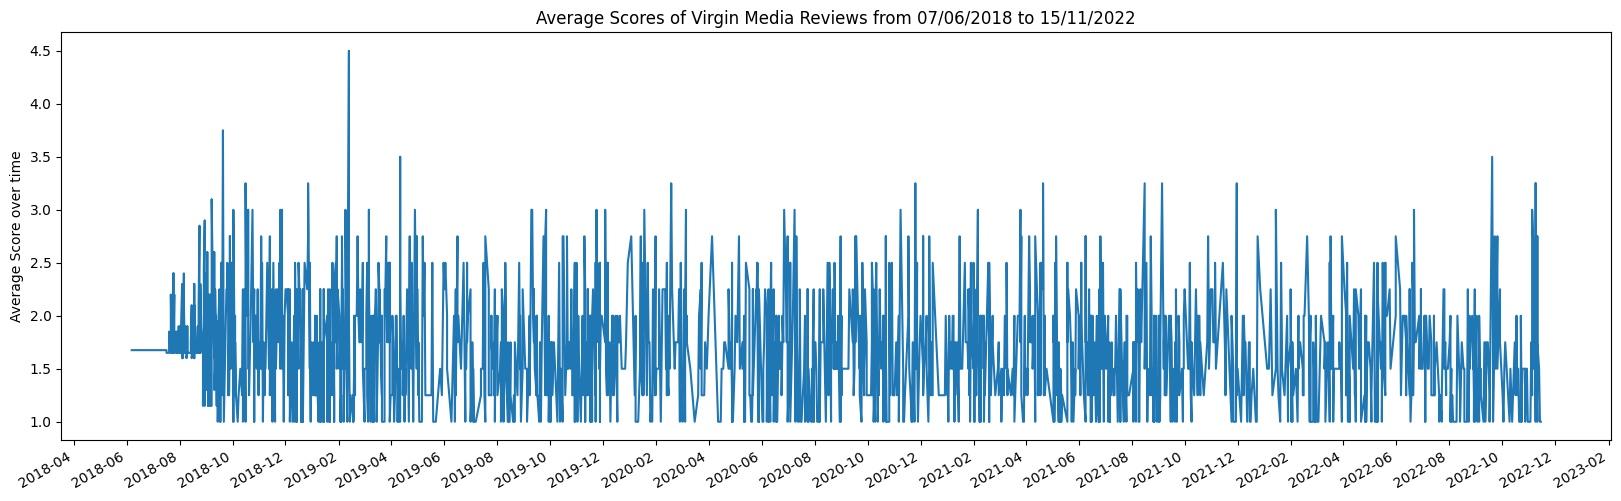

In [4]:
y_scores=np.array(df["Average Score"])
fig, ax=plt.subplots(figsize=(20, 6))
sixth_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(sixth_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) 
ax.plot(df["Dates"], df["Average Score"])
fig.autofmt_xdate()
# beautify the x-labels

ax.set_ylabel('Average Score over time')
ax.set_title("Average Scores of Virgin Media Reviews from 07/06/2018 to 15/11/2022", fontdict=None, loc='center')

The  Average score does not seem to be directly related to time. It fluctutates periodically through out the years but overall it does not seem to be direclty related to the average score of the reviews.. Thus we can safely drop this feature.

In [5]:
df=df.drop("Dates", axis=1, inplace=True)